In [2]:
# what each variable stands for
# cul_2_asr: The estimated number of people aged 18 years and over who disagree/strongly 
#     disagree with acceptance of other cultures
# disagreement with other culture

# discrim_past_yr_2_asr:The estimated number of people aged 18 years and over who, in the 
#     past 12 months, felt that they had experienced discrimination or have been treated 
#     unfairly by others 
# felt discrimination

# gsup_2_asr: The estimated number of people aged 18 years and over who are able to get support
#     in times of crisis from people outside the household
# support accessibility

# psup_2_asr: The estimated number of people aged 18 years and over (or their partner) who 
#     provide support to other relatives living outside the household
# support offer

# saf_2_asr: The estimated number of people aged 18 years and over who felt safe walking in
#     their local area after dark 
# felt safe in dark


# vol_past_yr_2_asr: The estimated number of people aged 18 years and over who did unpaid 
#     voluntary work in the last 12 months through an organisation 
# voluntary work

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import arange
from IPython.display import display

cs_df = pd.read_csv('LGA15_Community_Strength.csv',encoding = 'ISO-8859-1')
## crime rate dataset
or_df = pd.read_csv('offence_rate.csv',encoding = 'ISO-8859-1')
## community strength dataset
cs_df = cs_df[[' lga_name',' cul_2_asr',' discrim_past_yr_2_asr',' gsup_2_asr',' psup_2_asr',' saf_2_asr',' vol_past_yr_2_asr']]
cs_df = cs_df.drop(index = [len(cs_df)-1])
cs_df.columns = cs_df.columns.str.strip()
## unify lga name
cs_df['lga_name'] = cs_df['lga_name'].map(lambda x: x[:-4]).str.strip()
or_df.columns = ['lga_name', 'offence_rate']
## inner join 2 datasets, offence rate
df = cs_df.merge(or_df, how = 'inner', on = 'lga_name')
df.offence_rate = df.offence_rate.str.replace(',','').astype('float')
df['offence_rate'] = df['offence_rate'] / 1000
df.to_csv('vic-security.csv', index=False)


In [4]:
to_normalise = df.set_index('lga_name')
# calculating score for each variable for each lga by normalising data
#to_normalise = df[['cul_2_asr','discrim_past_yr_2_asr','gsup_2_asr','psup_2_asr','saf_2_asr','vol_past_yr_2_asr','offence_rate']]
normalized_df=((to_normalise-to_normalise.mean())/to_normalise.std())*100
#normalized_df.lga_name = df['lga_name']
normalized_df

# re-adjusting the score according to the context of each variable
normalized_df.cul_2_asr = -1*normalized_df.cul_2_asr
normalized_df.discrim_past_yr_2_asr = -1*normalized_df.discrim_past_yr_2_asr

# calulating overall score for each lga
normalized_df['overall score']= normalized_df.mean(axis=1)
#normalized_df.to_csv('vic-security-score.csv')

normalized_df
score_df = normalized_df.rename(columns = {'cul_2_asr':'cultural acceptance',
                                           'discrim_past_yr_2_asr':'inclusion',
                                           'gsup_2_asr':'support accessibility',
                                           'psup_2_asr':'benevolence',
                                           'saf_2_asr':'safety at night',
                                           'vol_past_yr_2_asr':'volunteer work',
                                           'offence_rate':'crime control'}, inplace = False)
score_df.to_csv('vic-security-score.csv')

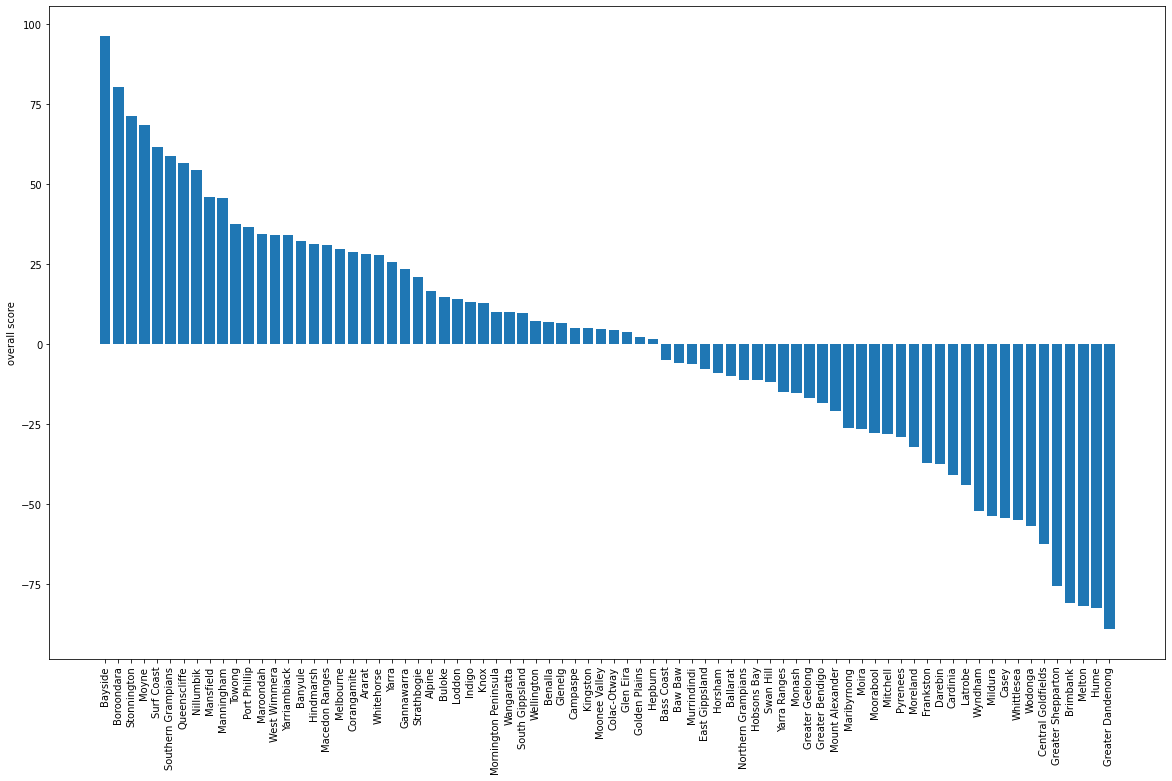

In [5]:
# bar chart
plt.figure(figsize=(20,12))
plot_us_df = pd.read_csv('vic-security-score.csv',encoding = 'ISO-8859-1')

plot_df=plot_us_df.sort_values(by="overall score", ascending = False)
#LGA_df = pd.read_csv('vic-security.csv',encoding = 'ISO-8859-1')
LGA_columns = plot_df["lga_name"]
LGA_score = plot_df['overall score']
plt.bar(arange(len(LGA_score)), LGA_score)
plt.xticks(arange(len(LGA_columns)),LGA_columns, rotation=90)
plt.ylabel("overall score")
plt.savefig('barchart.png')
plt.show()


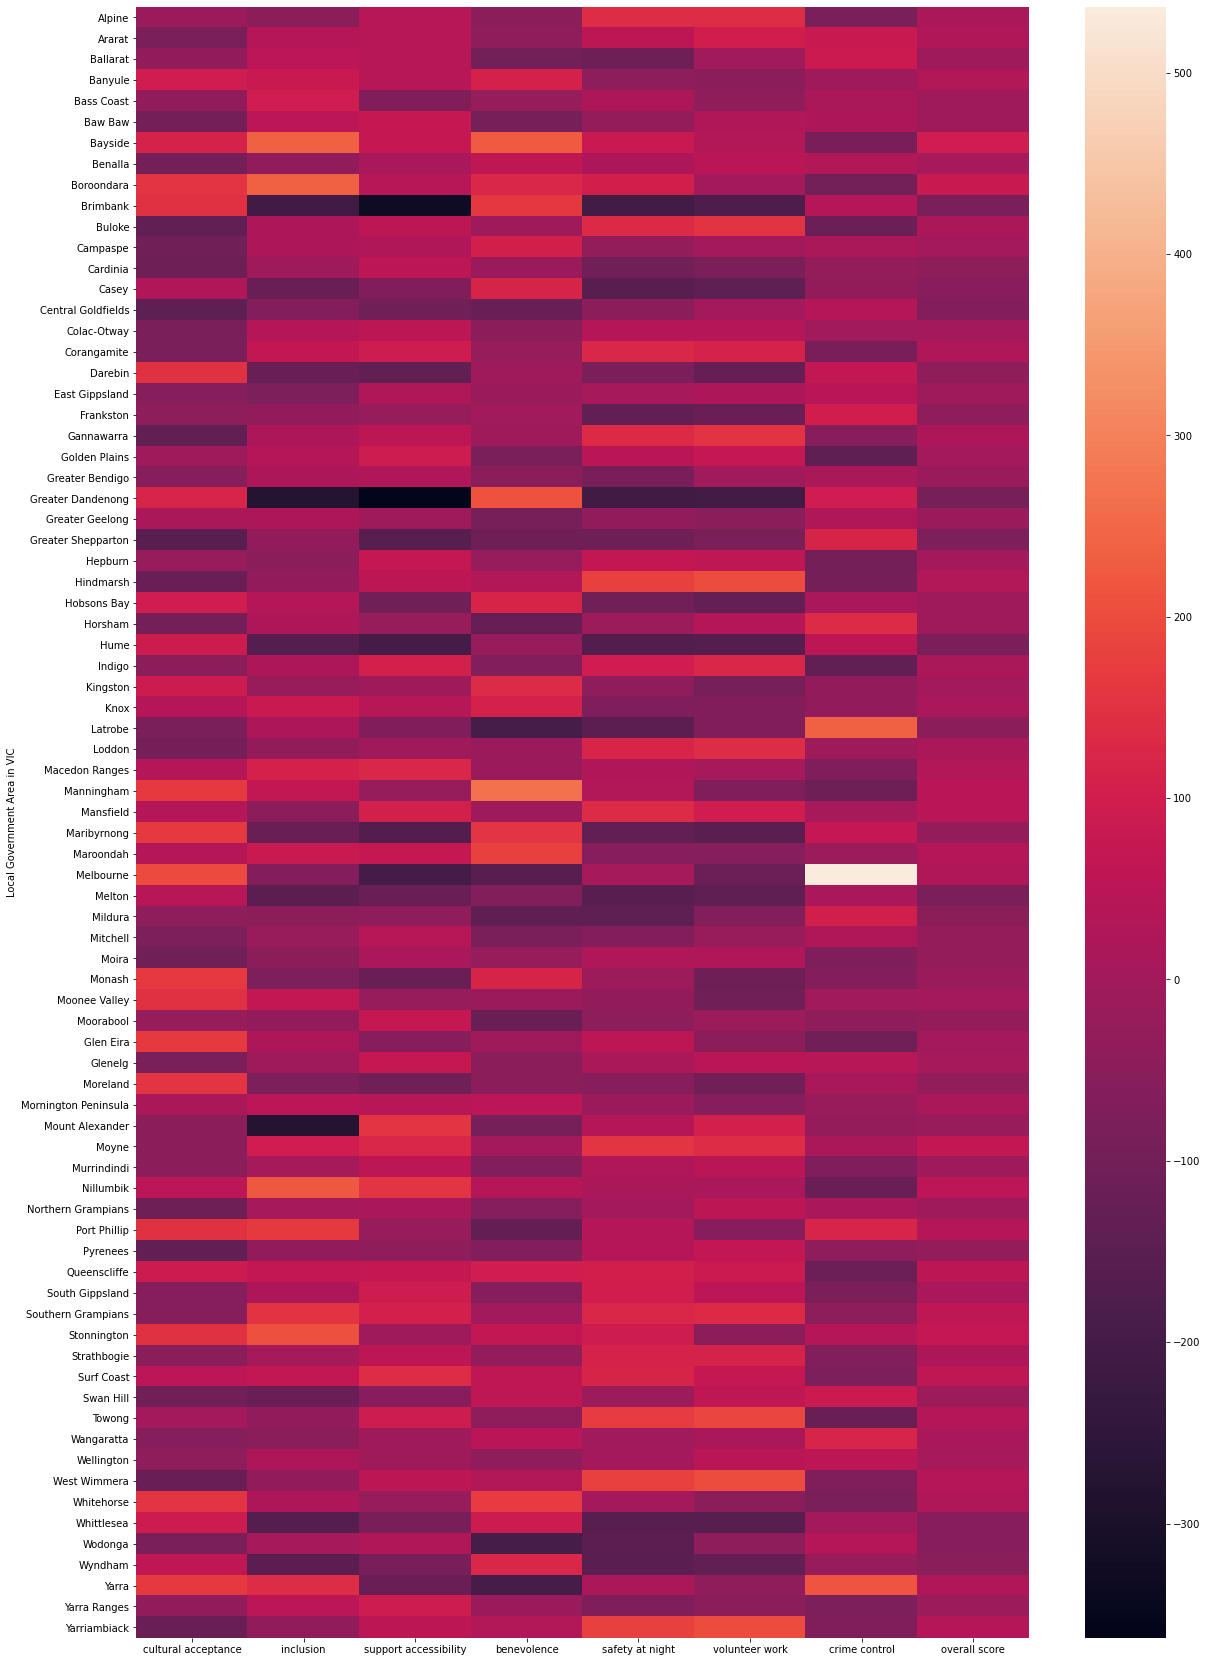

In [17]:
import matplotlib.pyplot as plt
import seaborn as sb

fig, ax = plt.subplots(figsize=(20, 30))
sb.heatmap(score_df)
plt.ylabel("Local Government Area in VIC")
plt.savefig('heatmap.png',transparent=False)
plt.show()


In [7]:
final_table = score_df['overall score'].sort_values(ascending = False).round(decimals=1)
final_table.to_csv('overall-score.csv')
final_table

lga_name
Bayside               96.2
Boroondara            80.3
Stonnington           71.1
Moyne                 68.3
Surf Coast            61.5
                      ... 
Greater Shepparton   -75.6
Brimbank             -81.0
Melton               -81.8
Hume                 -82.4
Greater Dandenong    -89.2
Name: overall score, Length: 78, dtype: float64

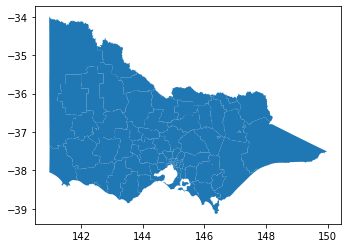

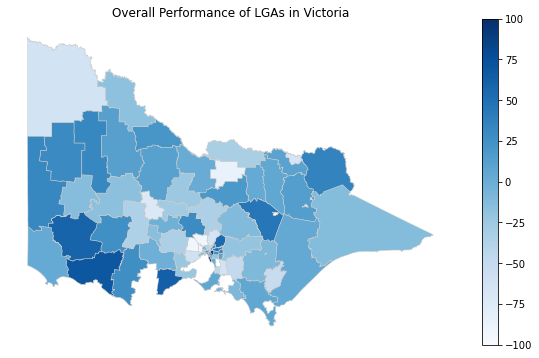

In [8]:
# code for chronopleth
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# set the filepath and load in a shapefile
fp = 'vic_lga_polygon_shp/VIC_LGA_POLYGON_SHP.shp'
map_df = gpd.read_file(fp)

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
# map_df.head(100)

map_df.plot()

df = pd.read_csv("vic-security-score.csv", header=0)
df['lga_name'] = df['lga_name'].str.upper()
# df.head(100)

# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index('ABB_NAME').join(df.set_index('lga_name'))
# merged.head(100)

# set a variable that will call whatever column we want to visualise on the map
variable = 'overall score'
# set the range for the choropleth
vmin, vmax = -100, 100
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10,6))

# create map
chronopleth = merged.plot(column=variable, cmap='Blues', linewidth=0.5, ax=ax, edgecolor='0.8')
chronopleth.set_title('Overall Performance of LGAs in Victoria')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

ax.axis('off')
plt.show()

fig.savefig('chronopleth_map_export.png')

In [11]:
# code for chronopleth with clustering
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering

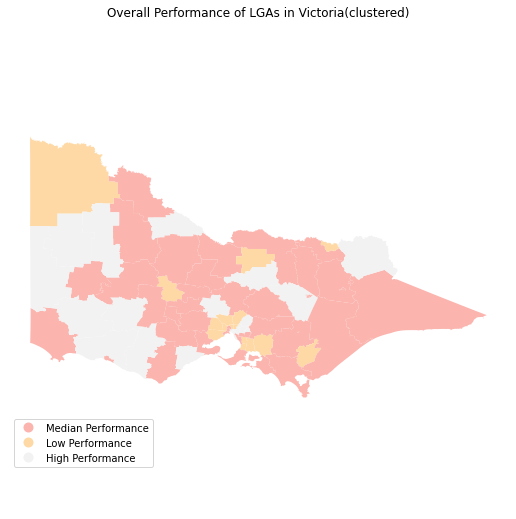

In [15]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=3)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(np.array(merged['overall score'].fillna(0)).reshape(-1, 1))

# Assign labels into a column
merged['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
merged.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax, cmap='Pastel1')

leg = ax.get_legend()
leg.get_texts()[0].set_text('Median Performance')
leg.get_texts()[1].set_text('Low Performance')
leg.get_texts()[2].set_text('High Performance')
leg.set_bbox_to_anchor((0.1, 0., 0.2, 0.2))
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Overall Performance of LGAs in Victoria(clustered)')
# Display the map
plt.show()

f.savefig('chronopleth_cluster.png')